In [1]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv('PhiUSIIL_Phishing_URL_Dataset.csv')

# Drop non-numeric columns
data = data.select_dtypes(include=['number'])

# Separate features and target
X = data.drop(columns='label')
y = data['label'].copy()  # Use .copy() to ensure no warnings for chained assignments

# Fix random seed for consistency
np.random.seed(42)

# Add noise to features
X += np.random.normal(0, 0.01, X.shape)

# Flip 10% of labels safely
num_flips = int(0.1 * len(y))
flip_indices = np.random.choice(len(y), size=num_flips, replace=False)
y.iloc[flip_indices] = 1 - y.iloc[flip_indices]

# Train/validation/test split with fixed seed
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters for XGBoost with fixed randomness
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 2,
    'learning_rate': 0.01,
    'reg_alpha': 50,
    'reg_lambda': 50,
    'min_child_weight': 15,
    'subsample': 0.4,
    'colsample_bytree': 0.4,
    'seed': 42,
    'random_state': 42
}

# Adjust boosting rounds dynamically based on data size
max_boost_rounds = 100 if len(y_train) > 1000 else 50

# Enable evals_result to track evaluation metrics
evals_result = {}

# Train the model with early stopping
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=max_boost_rounds,
    evals=[(dtrain, 'train'), (dval, 'eval')],
    early_stopping_rounds=10,
    evals_result=evals_result,  # Track evaluation metrics
    verbose_eval=False
)

# Predict on the test set
y_prob = xgb_model.predict(dtest)
y_pred = (y_prob > 0.5).astype(int)

# Evaluate the model
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_prob)
}

# Display metrics
print("\nTest Set Performance:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Prepare the DataFrame for performance metrics visualization
metrics_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"],
    "Value": list(metrics.values())
}
metrics_df = pd.DataFrame(metrics_data)



Test Set Performance:
Accuracy: 0.8977
Precision: 0.8966
Recall: 0.9232
F1 Score: 0.9097
AUC: 0.8963


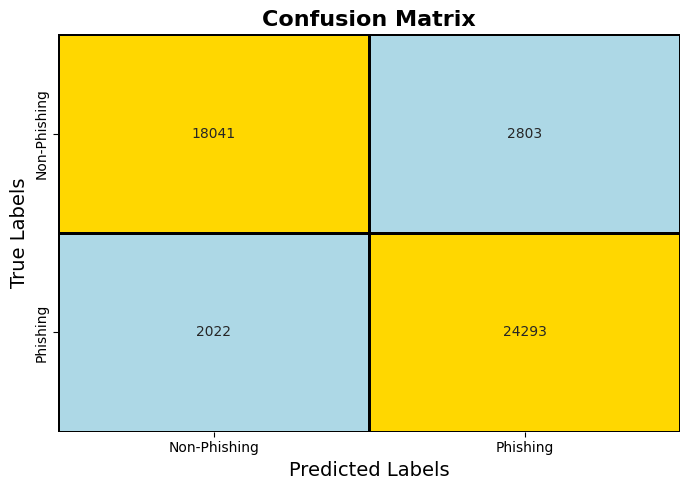

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix plot
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(
    cm,
    annot=True, 
    fmt="d", 
    cmap=sns.color_palette(["lightblue", "gold"], as_cmap=True),
    xticklabels=["Non-Phishing", "Phishing"],
    yticklabels=["Non-Phishing", "Phishing"],
    cbar=False,
    linewidths=1,
    linecolor="black"
)
plt.title("Confusion Matrix", fontsize=16, fontweight="bold")
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.tight_layout()
plt.show()


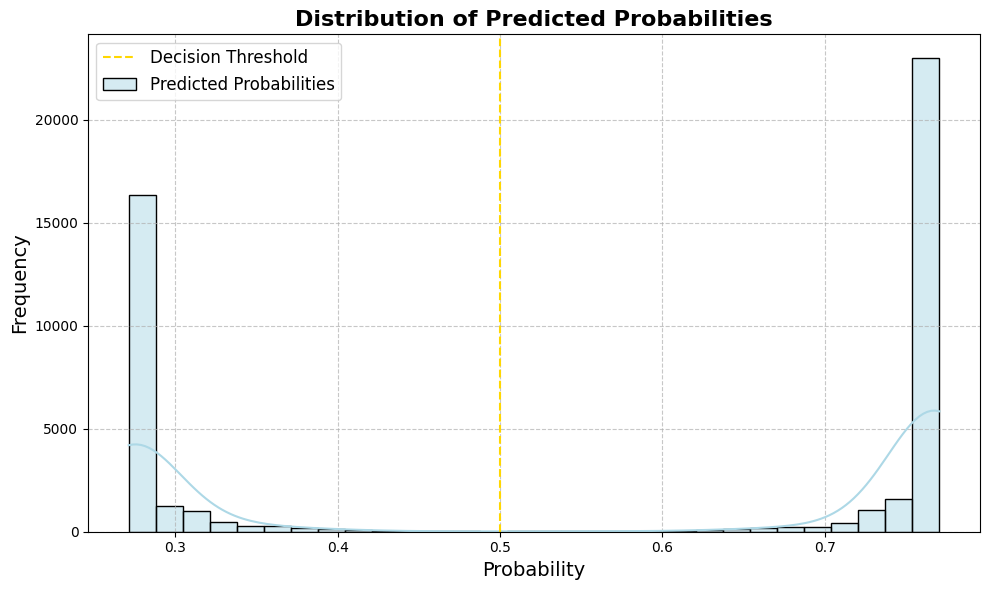

In [3]:
# Plot the distribution of predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(y_prob, bins=30, kde=True, color="lightblue", label="Predicted Probabilities")
plt.axvline(0.5, color="gold", linestyle="--", label="Decision Threshold")
plt.title("Distribution of Predicted Probabilities", fontsize=16, fontweight="bold")
plt.xlabel("Probability", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(fontsize=12)
plt.grid(linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

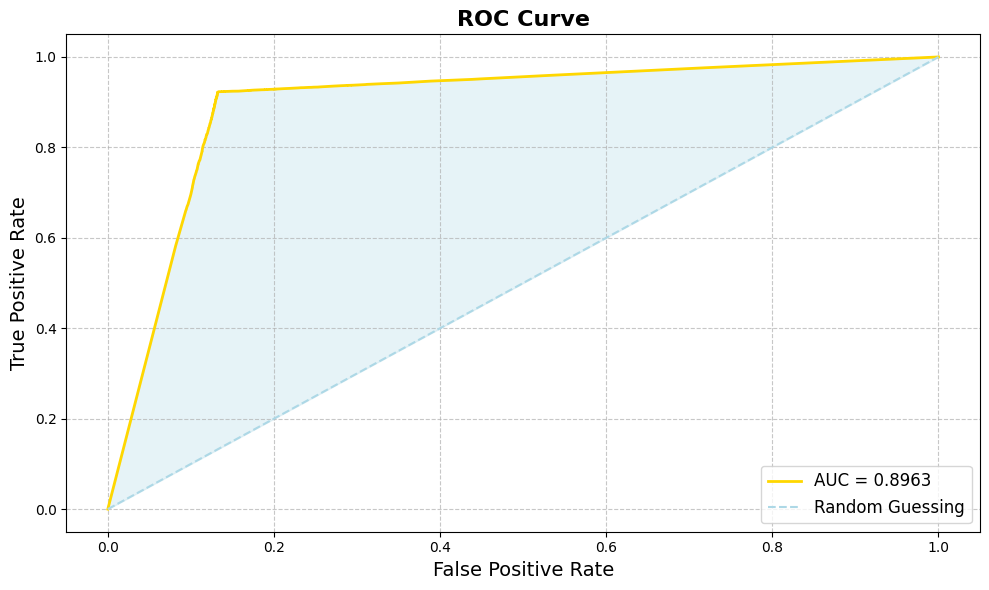

In [4]:
# Plot the ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color="gold", linewidth=2, label=f"AUC = {metrics['AUC']:.4f}")
plt.plot([0, 1], [0, 1], color="lightblue", linestyle="--", label="Random Guessing")
plt.title("ROC Curve", fontsize=16, fontweight="bold")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(fontsize=12)
plt.grid(linestyle="--", alpha=0.7)
plt.fill_between(fpr, fpr, tpr, color="lightblue", alpha=0.3, label="Model Performance")
plt.tight_layout()
plt.show()

/var/folders/_s/9l2qc1_d4050hwyms82s_8bw0000gn/T/ipykernel_42713/440133139.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Value", y="Metric", data=metrics_df, orient="h", palette="coolwarm")  # Gradient colors


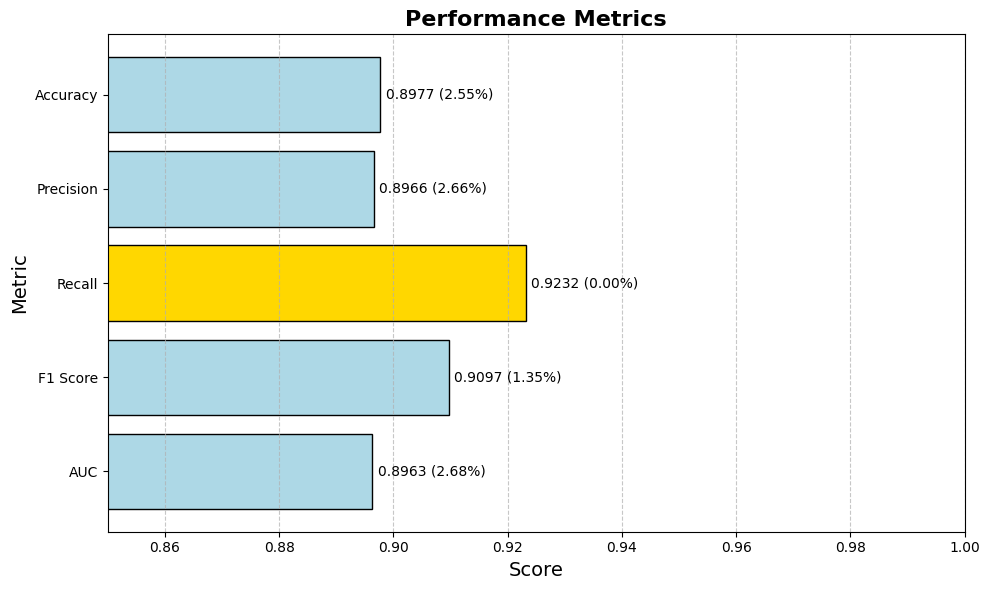

In [5]:
# Plot the bar chart with zoomed-in range and emphasis
plt.figure(figsize=(10, 6))  # Larger figure
sns.barplot(x="Value", y="Metric", data=metrics_df, orient="h", palette="coolwarm")  # Gradient colors

# Highlight the highest metric
best_metric = metrics_df.loc[metrics_df["Value"].idxmax()]
for i, (metric, value) in enumerate(zip(metrics_df["Metric"], metrics_df["Value"])):
    color = "gold" if metric == best_metric["Metric"] else "lightblue"
    plt.barh(i, value, color=color, edgecolor="black")

# Annotate metrics with differences
for i, value in enumerate(metrics_df["Value"]):
    diff = (best_metric["Value"] - value) * 100
    plt.text(value + 0.001, i, f"{value:.4f} ({diff:.2f}%)", va="center", fontsize=10)

# Adjust axes and titles
plt.title("Performance Metrics", fontsize=16, fontweight="bold")
plt.xlabel("Score", fontsize=14)
plt.ylabel("Metric", fontsize=14)
plt.xlim(0.85, 1)  # Focus on the top range of metrics
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [8]:
from sklearn.naive_bayes import GaussianNB

# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Predict on the test set
y_prob = nb_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob > 0.5).astype(int)

# Evaluate the model
nb_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_prob)
}
print("\nNaive Bayes Performance:")
print(nb_metrics)



Naive Bayes Performance:
{'Accuracy': 0.8274772577874849, 'Precision': 0.8660840146602763, 'Recall': 0.8171765152954589, 'F1 Score': 0.8409197559831066, 'AUC': 0.8853199776572842}


In [13]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_prob = rf_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob > 0.5).astype(int)

# Evaluate the model
rf_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_prob)
}
print("\nRandom Forest Performance:")
print(rf_metrics)



Random Forest Performance:
{'Accuracy': 0.8983863101422846, 'Precision': 0.897734412536497, 'Recall': 0.923047691430743, 'F1 Score': 0.9102150940568087, 'AUC': 0.8945696090130448}


In [10]:
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict on the test set
y_prob = dt_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob > 0.5).astype(int)

# Evaluate the model
dt_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_prob)
}
print("\nDecision Tree Performance:")
print(dt_metrics)



Decision Tree Performance:
{'Accuracy': 0.8041943213384508, 'Precision': 0.8255880446799588, 'Recall': 0.8229526885806574, 'F1 Score': 0.8242682601910707, 'AUC': 0.801732533121647}


In [11]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Predict on the test set
y_prob = lr_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob > 0.5).astype(int)

# Evaluate the model
lr_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_prob)
}
print("\nLogistic Regression Performance:")
print(lr_metrics)



Logistic Regression Performance:
{'Accuracy': 0.8561250238554676, 'Precision': 0.8366080661840745, 'Recall': 0.922287668630059, 'F1 Score': 0.8773610483506552, 'AUC': 0.8923343930408106}


/Users/ameyasamak/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
